In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/TSLA.csv'

In [ ]:
data = pd.read_csv(path)
start_date = '2015-01-01'
end_date = '2020-12-31'
data_1 = data[(data['Date']>= start_date) & (data['Date']<= end_date)]
df = data_1[['Date','Adj Close']]
df.head()
df.tail()

,Date,Adj Close
2642,2020-12-24,661.770020
2643,2020-12-28,663.690002
2644,2020-12-29,665.989990
2645,2020-12-30,694.780029
2646,2020-12-31,705.669983


In [ ]:
df['lag_1'] = df['Adj Close'].shift(1)
df['lag_2'] = df['Adj Close'].shift(2)
df['lag_5'] = df['Adj Close'].shift(5)
df['moving_avg_5'] = df['Adj Close'].rolling(window=5).mean()
df['moving_avg_20'] = df['Adj Close'].rolling(window=20).mean()
df['return'] = df['Adj Close'].pct_change()
df['volatility'] = df['return'].rolling(window=5).std()
df.dropna(inplace=True)
df.head()

,Date,Adj Close,lag_1,lag_2,lag_5,moving_avg_5,moving_avg_20,return,volatility
1155,2015-01-30,40.720001,41.040001,39.874001,40.257999,40.828001,40.6511,-0.007797,0.025514
1156,2015-02-02,42.188000,40.720001,41.040001,41.310001,41.003600,40.5674,0.036051,0.028064
1157,2015-02-03,43.672001,42.188000,40.720001,41.195999,41.498801,40.6501,0.035176,0.030613
1158,2015-02-04,43.709999,43.672001,42.188000,39.874001,42.266000,40.7228,0.000870,0.020638
1159,2015-02-05,44.198002,43.709999,43.672001,41.040001,42.897601,40.8232,0.011165,0.019901


In [ ]:
#train_data = df[(df['Date'] >= '2015-01-01') & (df['Date'] <= '2020-05-31')]
#test_data = df[(df['Date'] >= '2020-06-01') & (df['Date'] <= '2020-12-31')]
#train_data.index = pd.to_datetime(train_data['Date'])
#test_data.index = pd.to_datetime(test_data['Date'])
#plt.figure(figsize=(12,6))
#plt.plot(train_data['Adj Close'], label='Train Data')
#plt.plot(test_data['Adj Close'], label='Test Data')
#plt.title('Train and Test Data')
#plt.xlabel('Date')
#plt.ylabel('Adj Close')
#plt.legend()
#plt.show()

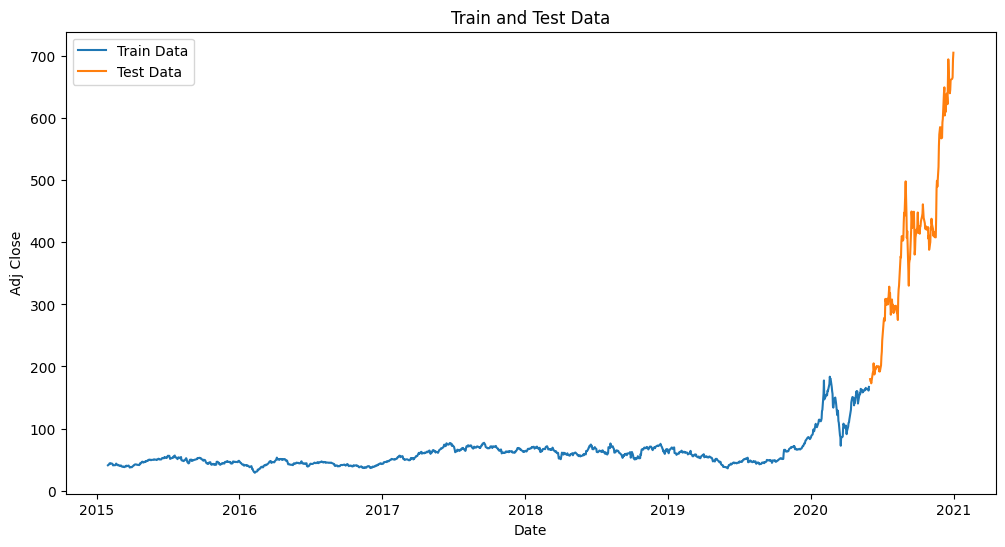

In [ ]:
train_data = df[:int(0.9*len(df))]
test_data = df[int(0.9*len(df)):]
train_data.index = pd.to_datetime(train_data['Date'])
test_data.index = pd.to_datetime(test_data['Date'])
plt.figure(figsize=(12,6))
plt.plot(train_data['Adj Close'], label='Train Data')
plt.plot(test_data['Adj Close'], label='Test Data')
plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

In [ ]:
X_train = train_data[['lag_1', 'lag_2','lag_5', 'moving_avg_5','moving_avg_20','return', 'volatility']]
y_train = train_data['Adj Close']

In [ ]:
from sklearn.model_selection import GridSearchCV
from re import X
import xgboost as xgb
from sklearn.metrics import mean_squared_error
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}
xgb_model = XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,scoring = 'neg_mean_squared_error', cv=5, verbose=1)
# Corrected the variable name from grid_serach to grid_search
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
X_test = test_data[['lag_1', 'lag_2','lag_5', 'moving_avg_5','moving_avg_20','return', 'volatility']]
y_test = test_data['Adj Close']
y_pred_test = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error:', mse)

Mean Squared Error: 72298.84610036678


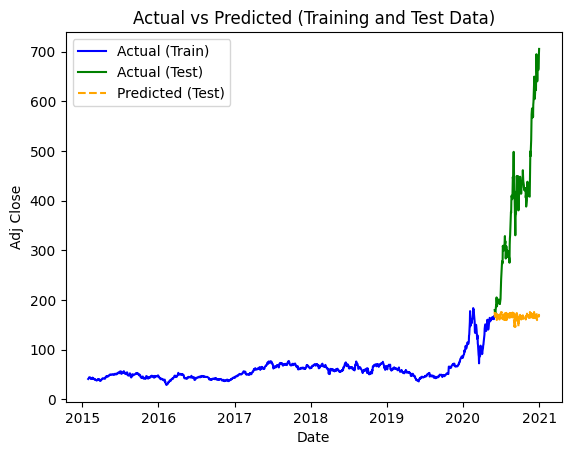

In [ ]:
plt.plot(y_train.index, y_train, label='Actual (Train)', color='blue')
#plt.plot(y_train.index, y_pred_train, label='Predicted (Train)', color='red', linestyle='--')

# Plot for test data
plt.plot(y_test.index, y_test, label='Actual (Test)', color='green')
plt.plot(y_test.index, y_pred_test, label='Predicted (Test)', color='orange', linestyle='--')

plt.title('Actual vs Predicted (Training and Test Data)')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

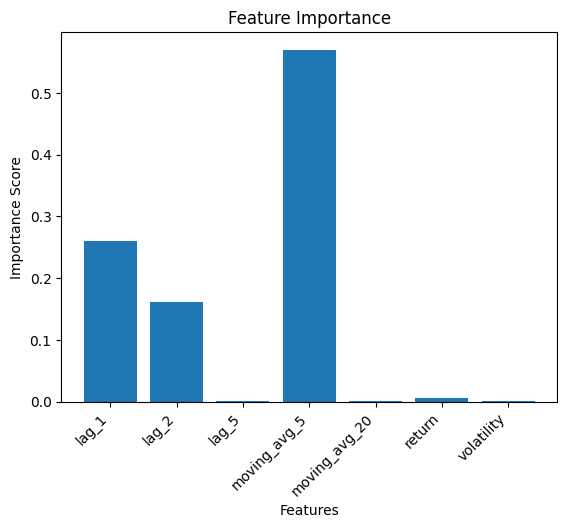

In [ ]:
     feature_importances = best_model.feature_importances_
     feature_names = X_train.columns

     plt.bar(feature_names, feature_importances)
     plt.xticks(rotation=45, ha='right')
     plt.xlabel('Features')
     plt.ylabel('Importance Score')
     plt.title('Feature Importance')
     plt.show()

In [ ]:
predicted_df = pd.DataFrame({'Date': test_data['Date'], 'Actual': y_test, 'Predicted': y_pred_test})
predicted_df.to_csv('/content/drive/MyDrive/predicted_values.csv', index=False)
print("Predicted values saved to: /content/drive/MyDrive/predicted_values.csv")

Predicted values saved to: /content/drive/MyDrive/predicted_values.csv


In [ ]:
print(predicted_df.index)

DatetimeIndex(['2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-11', '2020-06-12',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=150, freq=None)
